# Pipeline Overview

### Imports

In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
from tqdm import tqdm

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "utils")))

# Import Python Classes and Functions
from basic_augmentation import BasicAugmentation
from object_insertion import ObjectInsertion
from cloud_generator import cloud_generation

# Declare the directories
image_dir = "E:/Datasets/masati-thesis/images"
annot_dir = "E:/Datasets/masati-thesis/annotations"
obj_dir = "E:/Datasets/MasatiV2/MasatiV2Boats"

## Background Selection

In [20]:
# Sample a random images from the image directory
img_file = random.choice(os.listdir(image_dir))
print(f"The randomly selected image is {img_file}")

The randomly selected image is x0857.png


## Pre-processing

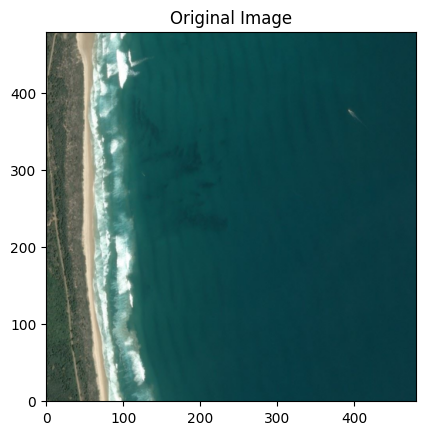

In [25]:
inserter = ObjectInsertion(
    img_dir=image_dir,
    obj_dir=obj_dir,
    xml_dir=annot_dir,
    out_dir="",
    input_size=512
)

processed_img = inserter.preprocess(image_dir + "/" + img_file)
plt.imshow(processed_img)
plt.gca().invert_yaxis()
plt.title("Original Image")
plt.show()

## Object Selection

In [35]:
# Sample a random images from the image directory
obj_file = random.choice(os.listdir(obj_dir))
print(f"The randomly selected image is {obj_file}")

The randomly selected image is x0053_boat1.png


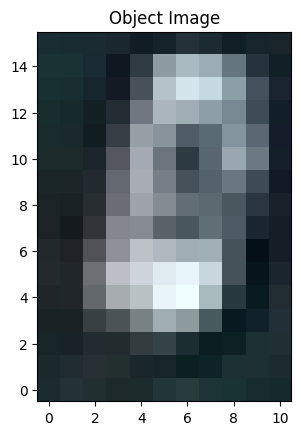

In [39]:
obj = cv2.imread(obj_dir + "/" + obj_file)
obj = cv2.cvtColor(obj, cv2.COLOR_BGR2RGB)
plt.imshow(obj)
plt.gca().invert_yaxis()
plt.title("Object Image")
plt.show()

## Object Masking

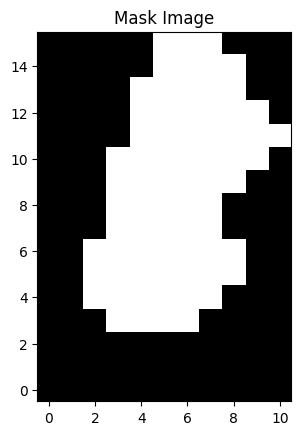

In [41]:
# Convert the object image to a binary mask
gray_obj = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce the noise
blur_mask = cv2.GaussianBlur(gray_obj, (5, 5), 0)

# Auto threshold using Otsu's method
_, binary_mask = cv2.threshold(blur_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological operations to clean the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
clean_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=1)
final_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(final_mask, cmap="gray")
plt.gca().invert_yaxis()
plt.title("Mask Image")
plt.show()

## Object Insertion

In [ ]:
# Perform object insertion


## Basic Augmentation

## Cloud Generation

## Synthetic Generation

## Object Detection

## Patchify